In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sint

: 

In [2]:
airfoil = np.loadtxt("NRELs826.txt", delimiter=",")
centroid = np.mean(airfoil, axis=0)

In [11]:
class TrailingEdgeFix:
    """
        Fixes trailing edge problem on airfoils for meshing, 
        and CFD applications. Main idea taken from PyAero
        airfoil analysis.
    
    """
    
    def __init__(self, airfoilpath): 
        
        self.airfoilpath = airfoilpath
        self.get_AirfoilSpline(150)
        self.calc_CurvatureProps()
        self.fix_TrailingEdge()
        
    def get_AirfoilSpline(self, points=300)->None: 
        """
            Parametrizes an airfoil based on a set points
            using Cubic Spline Interpolation.

        """
        try:
            self.airfoildata = np.loadtxt(self.airfoilpath, delimiter=",")
        except Exception as e:
            print(e)
        
        self.spl = sint.splprep(self.airfoildata.T, s=0.0, k=2)
        self.t = np.linspace(0, 1, points)
        self.coords = np.array(sint.splev(self.t, self.spl[0], der=0))
        self.d1 = sint.splev(self.t, self.spl[0], der=1)
        self.d2 = sint.splev(self.t, self.spl[0], der=2)
    
    def calc_CurvatureProps(self):
        """
            Calculates airfoil curve properties. 
        """
        x = self.coords[0]
        y = self.coords[1]
        x1d = self.d1[0]
        y1d = self.d1[1]
        x2d = self.d2[0]
        y2d = self.d2[1]
        
        num = x1d*y2d-y1d*x2d
        denom = (x1d**2+y1d**2)
        
        self.kappa = num/(denom**(3/2)) # curvature
        self.R = 1/self.kappa #radius of curvature
        
        self.xc = x - self.R*x1d/np.sqrt(denom)
        self.yc = y + self.R*y1d/np.sqrt(denom)
        
        self.leid = np.where(self.R == np.min(self.R))
        self.xle = self.xc[self.leid[0][0]]
        self.yle = self.yc[self.leid[0][0]]
               

    def fix_TrailingEdge(self):
        
        up_airfoil = self.coords[:, :self.leid[0][0]+1].T
        down_airfoil = self.coords[:,self.leid[0][0]:].T
        
        nupcoords = self.make_NewEdge(up_airfoil, 0.03, 0.02, 0.5, "upper")
        ndowncoords = self.make_NewEdge(down_airfoil, 0.04, 0.02, 0.5, "lower")
        self.newcoords = np.concatenate([nupcoords, ndowncoords[1:]], axis=0)
        self.newcoords = self.newcoords[~np.isnan(self.newcoords)].reshape(-1,2)
    
    
    @staticmethod
    def make_NewEdge(coords, blend, ex, thickness, side="upper"):
        xmin = np.min(coords[:,0])
        xmax = np.max(coords[:,0])
        length = xmax - xmin
        #print(length)
        thickness = length*thickness
        x = coords[:,0].copy()
        y = coords[:,1].copy()
        
        blend_points = np.where(coords[:,0] > (1-blend)*xmax)
    
        if side == "upper":
            signum = 1.0
            a = np.array([x[1]-x[0],
                         y[1]-y[0]])
            #print(a)
        elif side == "lower": 
            signum = -1.0
            a = np.array([x[-2]-x[-1],
                          y[-2]-y[-1]])
            
        e = a/np.sqrt(np.sum(a**2))
        #print(a)
        n = np.array([e[1],-e[0]])
        shift = 0.5*thickness
        for i in blend_points: 
            shift_blend = x[i] - xmax*(1.0 - blend)/\
                        (xmax*blend)
            x[i] = x[i]+signum*n[0]*shift_blend**ex*shift
            y[i] = y[i]+signum*n[1]*shift_blend**ex*shift
        
        return np.array([x, y]).T
    
    def make_SmoothEdge(self, ):
        """
            Use Bsplines to get a smooth edge on the airfoil.
        """
        sint.splev()
        
nrel = TrailingEdgeFix("NRELs826.txt")


/tmp/ipykernel_73244/3372395252.py:98: RuntimeWarning: invalid value encountered in power
  x[i] = x[i]+signum*n[0]*shift_blend**ex*shift
/tmp/ipykernel_73244/3372395252.py:99: RuntimeWarning: invalid value encountered in power
  y[i] = y[i]+signum*n[1]*shift_blend**ex*shift


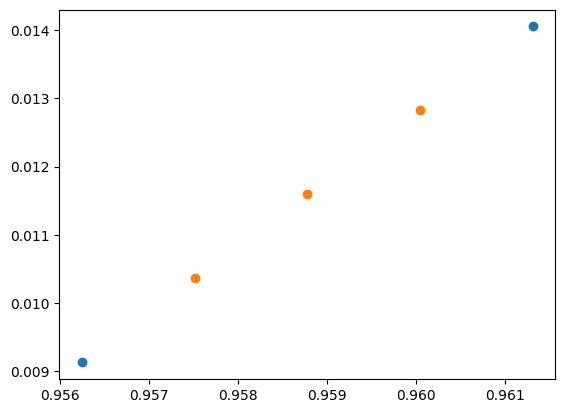

(-0.04575585384597876,
 1.009267779082619,
 -0.04818835246880534,
 0.11056897455770548)

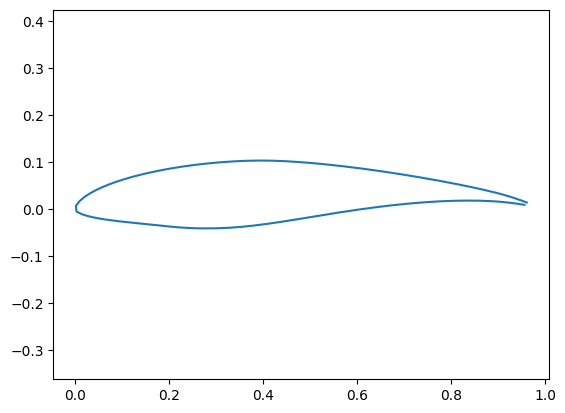

In [12]:
p1 = nrel.newcoords[0]
p2 = nrel.newcoords[-1]

plt.scatter([p1[0], p2[0]],
            [p1[1], p2[1]])

xlin = np.linspace(p1[0],p2[0],num=5)
ylin = np.linspace(p1[1],p2[1],num=5)

#rel.newcoords = np.append(nrel.newcoords, np.array([xlin[1:-1], ylin[1:-1]]).T, axis=0)
#print(nrel.newcoords)

plt.scatter(xlin[1:-1], ylin[1:-1])

plt.show()
plt.plot(nrel.newcoords[:,0], nrel.newcoords[:,1])
plt.axis('equal')

#np.savetxt("NRELs826altered.txt", nrel.newcoords, fmt="%1.4f", delimiter=",")


In [13]:
data1 = nrel.newcoords[:10]
data2 = nrel.newcoords[-10:]

def getSlopeB(points):
    deltas = points[1]-points[0] 
    m = deltas[1]/deltas[0]
    b = points[1,1] - m*points[1,0]
    return [m,b]

m1,b1 = getSlopeB(data1[:2])
m2,b2 = getSlopeB(data2[-2:])
x = (b2-b1)/(m1-m2)
y = m1*x+b1

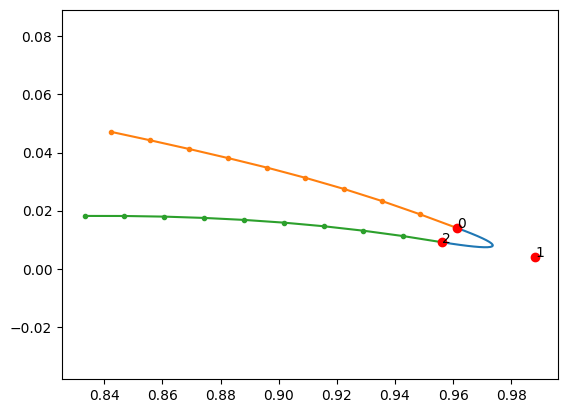

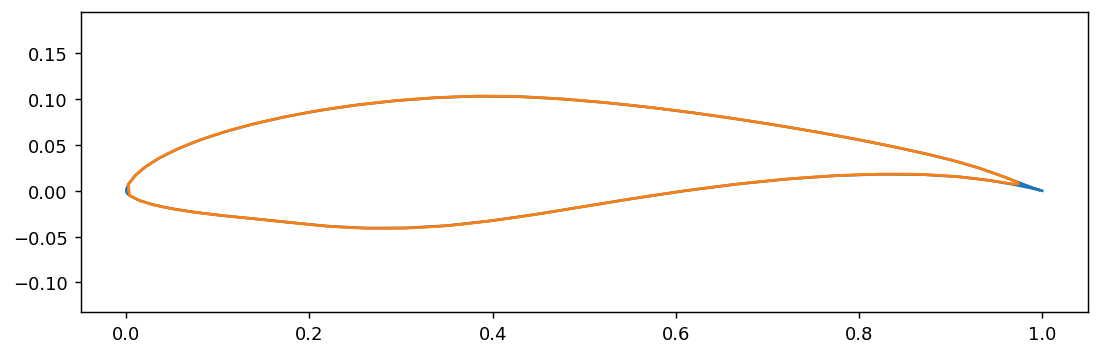

In [14]:
import numpy as np
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return np.array([xvals, yvals]).T

nPoints = 3
points = np.array([data1[0],
                  [x,y],
                  data2[-1]])
xpoints = [p[0] for p in points]
ypoints = [p[1] for p in points]

smoothedge = bezier_curve(points, nTimes=20)

plt.plot(smoothedge[:,0], smoothedge[:,1])
plt.plot(data1[:,0],data1[:,1],marker=".")
plt.plot(data2[:,0],data2[:,1],marker=".")
plt.plot(xpoints, ypoints, "ro")
for nr in range(len(points)):
    plt.text(points[nr][0], points[nr][1], nr)
plt.axis("equal")
plt.show()

fixedairfoil = np.concatenate([nrel.newcoords, smoothedge[1:-1]], axis=0) 
np.savetxt("NRELs826altered.txt", fixedairfoil, fmt="%1.4f", delimiter=",")
plt.figure(figsize=(10,3),dpi=130)
plt.plot(nrel.airfoildata[:,0], nrel.airfoildata[:,1])

plt.plot(fixedairfoil[:,0], fixedairfoil[:,1])

plt.axis('equal')
plt.show()